# **Flux Balance Analysis (FBA) Tutorial**

This tutorial was generated in July 2021 by Daniel Segrè, as part of the KITP school on microbial ecosystems. Some of the material was adapted from the Boston University course BF571 ("Dynamics and evolution of biological networks").




## Some relevant references

**Early concept of stoichiometric modeling:**
Papoutsakis ET., Equations and calculations for fermentations of butyric acid bacteria. Biotechnol Bioeng. 1984 Feb;26(2):174-87. https://onlinelibrary.wiley.com/doi/10.1002/bit.260260210 

**First paper with current formulation:**
Varma and Palsson, Metabolic Flux Balancing: Basic Concepts, Scientific and Practical Use, Nature Biotech 1994, https://www.nature.com/articles/nbt1094-994

**A useful didactic paper:**
Rawls et al., A simplified metabolic network reconstruction to promote understanding and development of flux balance analysis tools, Comput Biol Med
. 2019 Feb;105:64-71. https://pubmed.ncbi.nlm.nih.gov/30584952/ 

**COBRA toolbox for Matlab:**
Becker et al.,  Quantitative prediction of cellular metabolism with constraint-based models: the COBRA Toolbox, Nat Protoc 2007;2(3):727-38. https://www.nature.com/articles/nprot.2007.99

**Testing of FBA and exploration of suboptimal space:**
Segrè et al., Analysis of optimality in natural and perturbed metabolic networks, PNAS 2020. https://www.pnas.org/content/99/23/15112.long 




## Summary of basic formulation of FBA

X = vector of metabolite concentrations. X = (X_1,X2,...XM). Xj = Xj(t)

V = vecor of fluxes (reaction rates). V = (V1,V2,...VN). In general Vj = Vj(X,E,params), where E is the vector of enzyme concentrations.

S = stoichiometric matrix. Sij = moles of metabolite i (Xi) participating in reaction j (Vj). Sij>0 if metabolite i is defined as a product, Sij<0 if metabolite i is defined as a reactant.

Dynamical equations: dX/dt = S*V

Steady state equation: dX/dt = 0 ==> S*V = 0

Additional inequality constraints: LBj <= Vj <= UBj

Objective function: c = (c1,c2,...,cN); 

FBA problem:

            max c*V
            Subject to:
                        Sv=0
                        LBj<=Vj<=UBj


FLUX UNITS: mmol/(grDW*h)

## Libraries Used

numpy, seaborn, matplotlib, scipy, cobrapy, time


## **Part 1: FBA from scratch, elementary example**

This example is from Bonarius et al., "Flux analysis of underdetermined metabolic networks: the quest for the missing constraints", Trends in Biotechnology 1997, 
https://www.cell.com/trends/biotechnology/fulltext/S0167-7799(97)01067-6 


(Note: this part also contains some general purpose functions for visualization of FBA data)

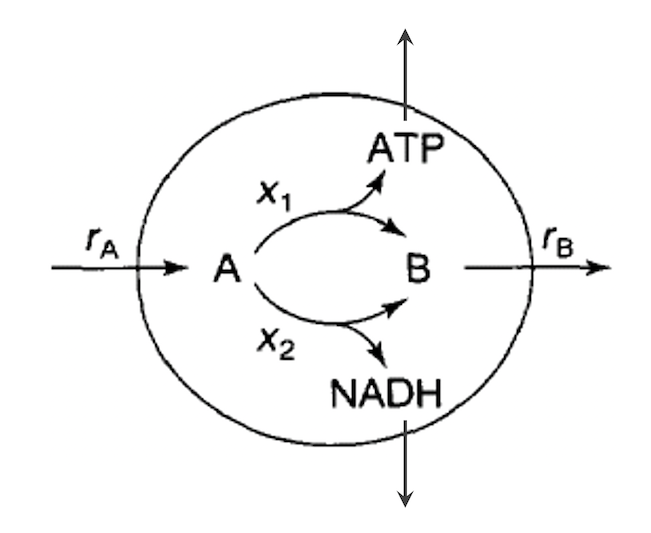

### Import Libraries

Import essential libraries, including basic numerical and graphics library and scipy optimization library. 

In [ ]:
import numpy as np # Imports Python numerical library
import seaborn as sns # Imports Library for drawing heatmaps
import matplotlib.pyplot as plt # Import Library for plotting graphs
from scipy.optimize import linprog # Imports Linear Programming function
from scipy.optimize import linprog_verbose_callback # Imports Linear Programming function

### Define reaction network

Define reaction network, i.e. stoichiometric matrix and labels of metabolites and reactions

STOICHIOMETRIC MATRIX


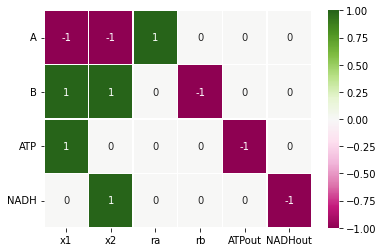

In [ ]:
# Labels of reactions: 
reacs =["x1","x2","ra","rb","ATPout","NADHout"]
# Labels of metabolites:
metabs = ["A","B","ATP","NADH"]

n = len(reacs) # Number of reactions
m = len(metabs) # Number of metabolites

# Define values of Stoichiometric Matrix
S=np.array([[ -1, -1,  1,  0,  0,  0],
            [  1,  1,  0, -1,  0,  0],
            [  1,  0,  0,  0, -1,  0],
            [  0,  1,  0,  0,  0, -1]])
           
print("STOICHIOMETRIC MATRIX")
colormap = sns.color_palette("Greens") 
sns.heatmap(S, annot=True,  linewidths=.5, xticklabels=reacs,yticklabels=metabs,cmap="PiYG")
plt.yticks(rotation=0) 
plt.show()

### Define optimization parameters

Define optimization parameters, i.e. flux lower bounds (LB) and upper bounds (UB), and objective function

---




In [ ]:
b=np.zeros(m) # Right-hand side of SV=0
obj=np.zeros(n) # Initialize Objective function vector to zero
LARGE = 1000 # Large number to be used as "Infinite" for flux bounds
LB=0*np.ones(n) # Set of lower bounds, initialize to zero
UB=LARGE*np.ones(n) # Set of upper bounds, initialize to LARGW

# Change flow through individual reaction
UB[2]=1

LBUB = np.transpose(np.stack((LB,UB),axis=0)) # Combine LB, UB into set of pairs [LB,UB]

obj[0]=-1 # Define objective function. Default of optimizer is "minimize", so a -1 will lead to maximization
obj[1]=0 # Define objective function. Default of optimizer is "minimize", so a -1 will lead to maximization


### Run LP to solve FBA

Perform Linear Programming (LP) calculation to solve FBA

In [ ]:
print("IMPLEMENT OPTIMIZATION:")
options = {"disp": False}
solution = linprog(c=obj, A_eq=S, b_eq=b, bounds=LBUB, options=options) # max c*v, given Sv=b, LB < v <UB
#print(solution)
# A_eq*v=b_eq --> SV=0

print("Optimization status (0:successful; 1:Iteration limit reached; 2:Infeasible; 3:Unbounded; 4:Numerical difficulties): ",solution.status)
print("Optimal value: ",solution.fun)
print("Solution vector: ", solution.x)

IMPLEMENT OPTIMIZATION:
Optimization status (0:successful; 1:Iteration limit reached; 2:Infeasible; 3:Unbounded; 4:Numerical difficulties):  0
Optimal value:  -0.9999999999956066
Solution vector:  [1.00000000e+00 2.17191515e-12 1.00000000e+00 1.00000000e+00
 1.00000000e+00 2.17191515e-12]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### Display solution

Visualize Solution vector

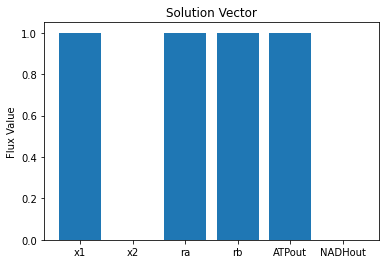

In [ ]:
v_pos = np.arange(n)
plt.bar(v_pos, solution.x, align='center')
plt.xticks(v_pos, reacs)
plt.ylabel('Flux Value')
plt.title('Solution Vector')
plt.show()

Define function for displaying list of reactions and associated fluxes

In [ ]:
# Pretty Print Reactions and their fluxes
def pretty_print_fluxes(_S,_reacs,_metabs,_solution):
  flux_vec = _solution.x #  flux vector
  for col in range(_S.shape[1]): 
    reac_string=_reacs[col] + "[Flux = "+ str(round(flux_vec[col],2)) + "] : "
    curr_col=_S[:, col]
    curr_col_pos= np.where(curr_col > 0)[0] 
    curr_col_neg= np.where(curr_col < 0)[0] 


    if len(curr_col_neg)>0:
      #print("Products")
      for f in curr_col_neg:
        #print(_metabs[f])
        reac_string=reac_string+" "+str(-curr_col[f])+" "+_metabs[f]
    reac_string = reac_string + " ===> "

    if len(curr_col_pos)>0:
      #print("Substrates")
      for f in curr_col_pos:
        reac_string=reac_string+" "+str(curr_col[f])+" "+_metabs[f]

    print(reac_string)


Test pretty_print_fluxes function on super-simple network:[link text](https://)

In [ ]:
pretty_print_fluxes(S,reacs,metabs,solution)

x1[Flux = 1.0] :  1 A ===>  1 B 1 ATP
x2[Flux = 0.0] :  1 A ===>  1 B 1 NADH
ra[Flux = 1.0] :  ===>  1 A
rb[Flux = 1.0] :  1 B ===> 
ATPout[Flux = 1.0] :  1 ATP ===> 
NADHout[Flux = 0.0] :  1 NADH ===> 


### Draw network with fluxes

Define function for drawing graph of metabolic network, with arrow thickness proportional to fluxes

In [ ]:
def draw_network(_S,_reacs,_metabs,_solution):

  import networkx as nx
  flux_vec = _solution.x #  flux vector
  thickness_factor = 7
  norm_flux = thickness_factor*flux_vec /max(abs(flux_vec)) # Computes normalized flux vector for drawing network
  G = nx.DiGraph()
  G.add_nodes_from(_metabs)
  G.add_nodes_from(_reacs)
  for col in range(_S.shape[1]): 
    reac_string=_reacs[col] + "[Flux = "+ str(round(flux_vec[col],2)) + "] : "
    curr_col=_S[:, col]
    curr_col_pos= np.where(curr_col > 0)[0] 
    curr_col_neg= np.where(curr_col < 0)[0] 

    if len(curr_col_neg)>0:
      for f in curr_col_neg:
        G.add_edge(_metabs[f],_reacs[col],weight=norm_flux[col])    

    if len(curr_col_pos)>0:
      for f in curr_col_pos:
        G.add_edge(reacs[col],metabs[f],weight=norm_flux[col])

  #pos = nx.spring_layout(G,weight=0)
  pos = nx.kamada_kawai_layout(G,weight=0)
  #pos = nx.circular_layout(G)

  edges = G.edges()
  #colors = [G[u][v]['color'] for u,v in edges]
  weights = [G[u][v]['weight'] for u,v in edges]

  #nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)
  nx.draw(G, pos, with_labels=True,node_size = 700, node_color=[[0.4, 0.7, 0.9]],width=weights)

Test draw_network function

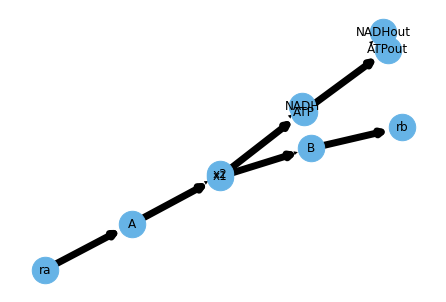

In [ ]:
draw_network(S,reacs,metabs,solution)

### Questions

1. What would happen in absence of the "ATP out" and "NADH out" reactions?
2. What geometrical entity represents the feasible space for this problem?



### Alternative LP package for solving FBA (CVXPY)
Information available here: https://www.cvxpy.org/

In [ ]:
import cvxpy as cp
v=cp.Variable(n)

obj=np.zeros(n) # Initialize Objective function vector to zero
#obj[0]=-1 # Define objective function. Default of optimizer is "minimize", so a -1 will lead to maximization
obj[3]=-1 # Define objective function. Default of optimizer is "minimize", so a -1 will lead to maximization

objective=cp.Maximize(cp.matmul(-obj,v))
constraints = [cp.matmul(S,v)==0,v<=UB,v>=LB]
prob = cp.Problem(objective,constraints)
result=prob.solve(verbose=True)
print("Solution vector:",v.value)


Solution vector: [0.5 0.5 1.  1.  0.5 0.5]


In [ ]:
# Line below prints dual variables (Lagrange multipliers) associated with equality constraints
print("Lagrange dual variable", constraints[0].dual_value)


Lagrange dual variable [-1.00000000e+00 -1.00000000e+00 -4.18490798e-12 -4.18490798e-12]


### Yet another LP package for solving FBA (optlang)

In [ ]:
pip install optlang

In [ ]:
# EXAMPLE (NOT FBA - not sure it's a good way to go...)
from optlang import Model, Variable, Constraint, Objective

# All the (symbolic) variables are declared, with a name and optionally a lower and/or upper bound.
x1 = Variable('x1', lb=0)
x2 = Variable('x2', lb=0)
x3 = Variable('x3', lb=0)

# A constraint is constructed from an expression of variables and a lower and/or upper bound (lb and ub).
c1 = Constraint(x1 + x2 + x3, ub=100)
c2 = Constraint(10 * x1 + 4 * x2 + 5 * x3, ub=600)
c3 = Constraint(2 * x1 + 2 * x2 + 6 * x3, ub=300)

# An objective can be formulated
obj = Objective(10 * x1 + 6 * x2 + 4 * x3, direction='max')

# Variables, constraints and objective are combined in a Model object, which can subsequently be optimized.
model = Model(name='Simple model')
model.objective = obj
model.add([c1, c2, c3])

status = model.optimize()

print("status:", model.status)
print("objective value:", model.objective.value)
print("----------")
for var_name, var in model.variables.iteritems():
    print(var_name, "=", var.primal)

status: optimal
objective value: 733.3333333333333
----------
x1 = 33.33333333333333
x2 = 66.66666666666667
x3 = 0.0


## **Part 2: FBA from scratch, slightly less trivial example**

This is a slightly more realistic network, capturing some key features of a real core metabolic network, with energy generation (both fermentation and respiration), biomass production and non-growth-associated maintenance. (Model made up by Daniel Segrè for teaching purpose)

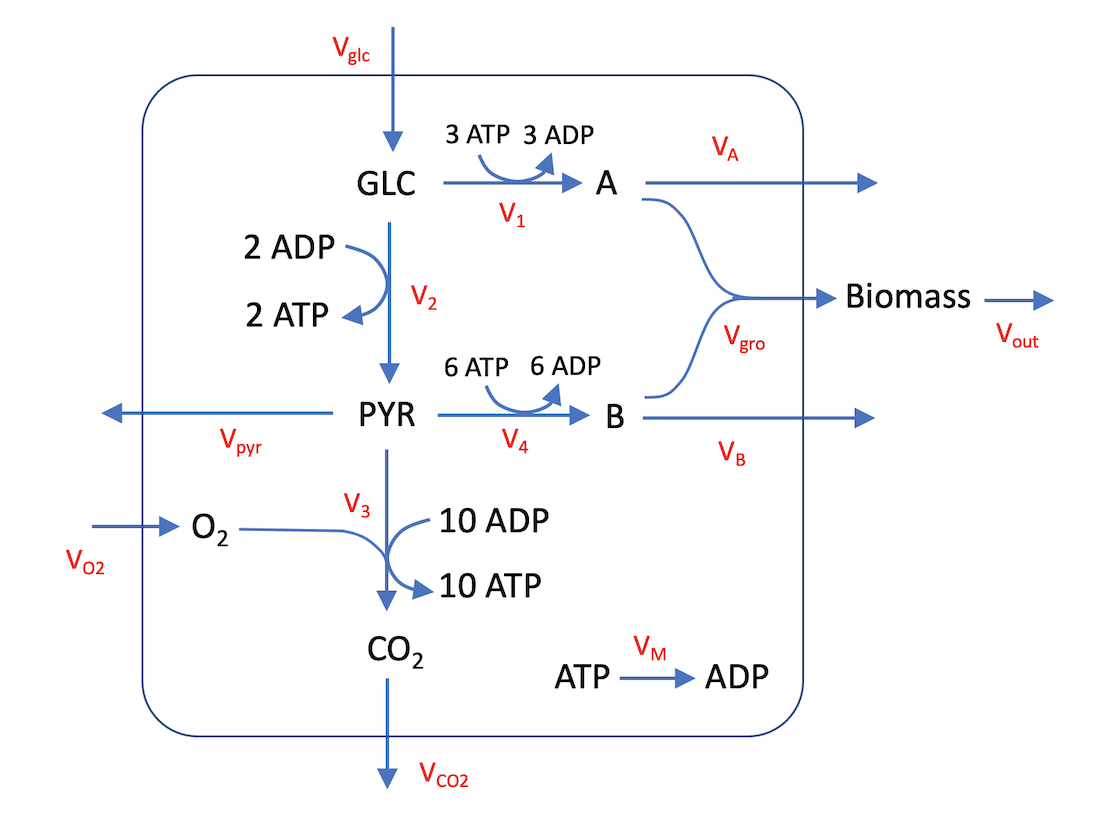

### Define Reaction Network

STOICHIOMETRIC MATRIX


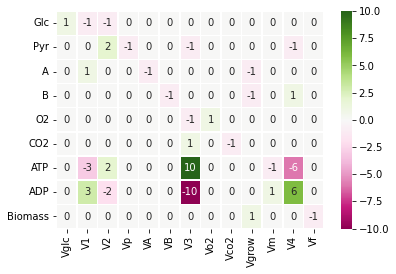

In [ ]:
reacs =["Vglc","V1","V2","Vp","VA","VB","V3","Vo2","Vco2","Vgrow","Vm","V4","Vf"]
metabs = ["Glc","Pyr","A","B","O2","CO2","ATP","ADP","Biomass"]

n = len(reacs)
m = len(metabs)

S=np.array([[1  , -1  ,  -1 ,    0  ,   0  ,   0  ,   0  ,   0  ,   0   ,  0  ,   0   ,  0   ,  0],
[0  ,  0   ,  2   , -1   ,  0   ,  0   , -1  ,   0  ,   0  ,   0   ,  0  ,  -1  ,   0],
[0  ,  1  ,   0   ,  0  ,  -1   ,  0  ,   0  ,   0  ,   0  ,  -1   ,  0   ,  0  ,   0],     
[0  ,  0  ,   0   ,  0   ,  0  ,  -1   ,  0  ,   0   ,  0  ,  -1   ,  0   ,  1  ,   0],    
[0  ,  0  ,   0   ,  0   ,  0   ,  0  ,  -1   ,  1   ,  0  ,   0   ,  0  ,   0   ,  0],     
[0  ,  0  ,   0   ,  0  ,   0   ,  0   ,  1   ,  0  ,  -1  ,   0   ,  0  ,   0   ,  0],     
[0  , -3  ,   2  ,   0  ,   0   ,  0   , 10  ,   0  ,  0   ,  0  ,  -1  ,  -6  ,  0],     
[0  ,  3  ,  -2  ,   0   ,  0   ,  0  , -10  ,   0  ,   0   ,  0  ,   1   ,  6  ,  0],    
[0  ,  0  ,   0  ,   0   ,  0   ,  0  ,   0   ,  0   ,  0   ,  1   ,  0   ,  0   , -1]])

print("STOICHIOMETRIC MATRIX")
colormap = sns.color_palette("Greens") 
sns.heatmap(S, annot=True,  linewidths=.5, xticklabels=reacs,yticklabels=metabs,cmap="PiYG")
plt.yticks(rotation=0) 
plt.show()

##Define optimization parameters

Define optimization parameters, i.e. flux lower bounds (LB) and upper bounds (UB), and objective function

In [ ]:
b=np.zeros(m) # Right-hand side of SV=0
obj=np.zeros(n) # Initialize Objective function vector to zero
LARGE = 1000 # Large number to be used as "Infinite" for flux bounds
LB=0*np.ones(n) # Set of lower bounds, initialize to zero
UB=LARGE*np.ones(n) # Set of upper bounds, initialize to LARGW

# Change flow through individual reaction
UB[0]=10
UB[7]=3

LBUB = np.transpose(np.stack((LB,UB),axis=0)) # Combine LB, UB into set of pairs [LB,UB]

obj[12]=-1 # Define objective function. Default of optimizer is "minimize", so a -1 will lead to maximization
#obj[3]=-1
print("Objetive function:", obj)
#print(LBUB)
#print(S)
#print(S.shape)
#print(len(reacs))
#print(len(metabs))


Objetive function: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]


### Run LP to solve FBA

In [ ]:
print("IMPLEMENT OPTIMIZATION:")
options = {"disp": False}
solution = linprog(c=obj, A_eq=S, b_eq=b, bounds=LBUB, options=options) # max c*v, given Sv=b, LB < v <UB
#print(solution)

print("Optimization status (0:successful; 1:Iteration limit reached; 2:Infeasible; 3:Unbounded; 4:Numerical difficulties): ",solution.status)
print("Optimal value: ",solution.fun)
print("Solution vector: ", solution.x)

### Display Solution

Visualize Solution Vector

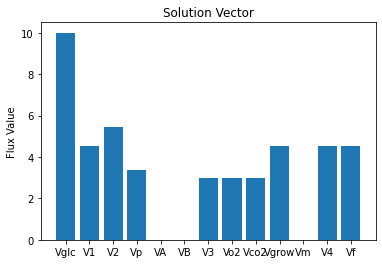

In [ ]:
v_pos = np.arange(n)
plt.bar(v_pos, solution.x, align='center')
plt.xticks(v_pos, reacs)
plt.ylabel('Flux Value')
plt.title('Solution Vector')
plt.show()

### Print and visualize fluxes

Vglc[Flux = 10.0] :  ===>  1 Glc
V1[Flux = 4.55] :  1 Glc 3 ATP ===>  1 A 3 ADP
V2[Flux = 5.45] :  1 Glc 2 ADP ===>  2 Pyr 2 ATP
Vp[Flux = 3.36] :  1 Pyr ===> 
VA[Flux = 0.0] :  1 A ===> 
VB[Flux = 0.0] :  1 B ===> 
V3[Flux = 3.0] :  1 Pyr 1 O2 10 ADP ===>  1 CO2 10 ATP
Vo2[Flux = 3.0] :  ===>  1 O2
Vco2[Flux = 3.0] :  1 CO2 ===> 
Vy[Flux = 4.55] :  1 A 1 B ===>  1 Biomass
Vm[Flux = 0.0] :  1 ATP ===>  1 ADP
V4[Flux = 4.55] :  1 Pyr 6 ATP ===>  1 B 6 ADP
Vf[Flux = 4.55] :  1 Biomass ===> 


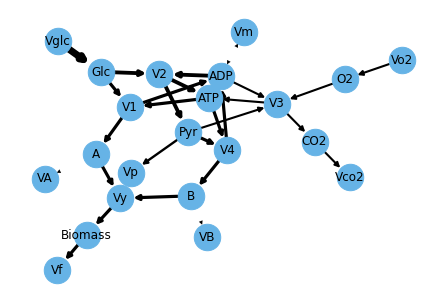

In [ ]:
pretty_print_fluxes(S,reacs,metabs,solution)
draw_network(S,reacs,metabs,solution)

### Questions for trainees

1. Can you write a loop to check which reactions ae non-essential?
2. How does the Maintenance flux (ATPM) affect the network function? 
3. How does the network behave under different assumptions about the objective function?
4. Can you impose a constraint on the total sum of the absolute values of the fuxes (advanced; best achieved with more sophisticated optimization package, like cvxpy) 

### Alternative LP package for solving FBA (CVXPY)

In [ ]:
import cvxpy as cp
v=cp.Variable(n)
objective=cp.Maximize(cp.matmul(obj,v))
constraints = [cp.matmul(S,v)==0,v<=UB,v>=LB]
prob = cp.Problem(objective,constraints)
result=prob.solve(verbose=True)
print("Solution vector:",v.value)


Solution vector: [8.55715634e-12 5.52356305e-01 5.52356305e-01 5.52356305e-01
 8.49683209e-12 5.52356305e-01]


### Calculating Carbon Use Efficiency

In [ ]:
# Create an FBA function to be called repeatedly
def LPFBA(S, LB, UB, obj=None):
  """
  Solve FBA with linear programming
  Inputs:
  | S: Stoichiometric matrix (reactions X metabolites) - LAST REACTION IS BIOMASS
  | UB: Lower bound and upper bound of each flux (# reactions X 1)
  | obj: Custom objective function (default is to maximize biomass)
  """
  # Get number of reactions
  n = S.shape[1]
  # Concatenate lower and upper bounds
  LBUB = np.array([LB, UB]).T

  # At steady state, b=0
  b = np.zeros(S.shape[0])

  if not obj:
    # Set objective
    obj = np.zeros(n)
    obj[-1] = -1
  
  solution = linprog(c=obj, A_eq=S, b_eq=b, bounds=LBUB)
  return solution

In [ ]:
"Vary glucose, o2, and maintainence"
# Save CUE for each glucose value
import pandas as pd

data = []
for glc in np.array([0.1, 1, 5, 10, 15, 20]):
  for o2 in np.array([0.1, 1, 2, 3, 4, 5]):
    for vm in np.array([0, 0.05 , 0.1]):
      # Specify upper bounds
      ub_dict = {'Vglc': glc, 'Vm': vm, 'Vo2': o2}
      # Use upper bound when specified, otherwise set infinite upper bound
      LB=0*np.ones(n) # Set of lower bounds, initialize to zero
      UB = [ub_dict.get(r, np.inf) for r in reacs]
      LB[10]=UB[10] # Fix matinenance flux

      "Run FBA"
      sol = LPFBA(S, LB, UB)
      reaction_fluxes = sol.x
      #print(sol.x)
      reaction_fluxes = dict(zip(reacs, sol.x))
      reaction_fluxes['Vgrow']


      "Compute CUE"
      # Carbon use efficiency = growth / (growth + respiration) [https://link.springer.com/article/10.1007/s10533-016-0191-y]
      cue = (6*reaction_fluxes['Vglc']-reaction_fluxes['Vco2']-3*reaction_fluxes['Vp']) / (6*reaction_fluxes['Vglc'])
      #cue = reaction_fluxes['Vgrow'] / sum([reaction_fluxes['Vgrow'], reaction_fluxes['Vco2']])     
      data.append({'glc': glc, 'o2': o2, 'vm': vm, 'cue': cue, 'status': sol.status})
df = pd.DataFrame(data)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,glc,o2,vm,cue,status
0,0.1,0.1,0.00,0.934959,0
1,0.1,0.1,0.05,0.928862,0
2,0.1,0.1,0.10,0.922764,0
3,0.1,1.0,0.00,0.934959,0
4,0.1,1.0,0.05,0.928862,0


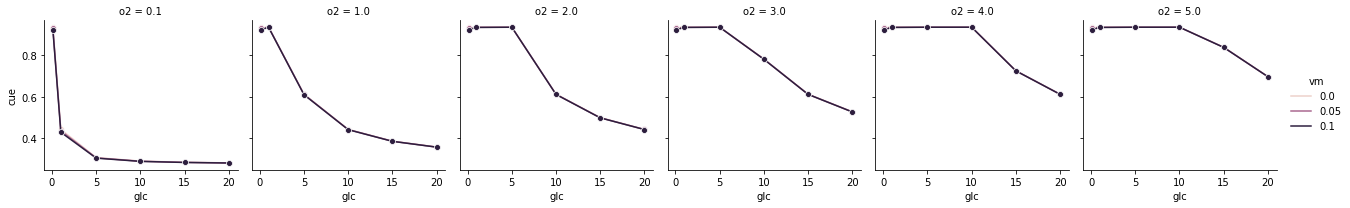

In [ ]:
"Visualize"
g = sns.relplot(x='glc', y='cue', hue='vm', col='o2', data=df, kind='line', marker='o', height=3)
plt.show()

## **PART 3: Genome-scale FBA models using CobraPy**


##Installation of **cobrapy**
Main page: https://opencobra.github.io/cobrapy/

Full documentation: https://cobrapy.readthedocs.io/en/latest/index.html

In [ ]:
# Install cobrapy library
!pip install cobra

##Import Libraries

Import libraries used in following scripts, including the cobrapy library

In [ ]:
# IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import cobra
from cobra.flux_analysis import flux_variability_analysis
import seaborn as sns # Imports Library for drawing heatmaps
import time

## Uploading a model into colab & cobrapy

The following function is just a convenient script we can use to upload models in different formats. It detects automatically the format from the file name, and uses the appropriate cobrapy built-in function. The three key formats are:

1. **.xml** - this is the standard model file in SBML (Systems Biology Markup Language). In the past there used to be different variants of SBML notation for FBA models. One may need to use some caution with older xml files.

2. **.mat** - this is the Matlab format, used in the original COBRA Toolbox built for Matlab. It is convenient to use if ones want to switch back and forth between Matlab and Python.

3. **.json** - json file, I think this is meant to be the standard in cobrapy.

In [ ]:
# UNIVERSAL MODEL UPLOAD FUNCTION
# This function detects automatically the format of a model and uploads it using cobrapy
# Possible formats: .mat, json, .xml
def read_model(_file_name):
  suffix = _file_name.split('.')[-1]
  print("Uploading model of type: ",suffix)
  if (suffix == 'xml'):
    _model = cobra.io.read_sbml_model(_file_name)
  elif (suffix == 'mat'):
    _model = cobra.io.load_matlab_model(_file_name)
  elif (suffix == 'json'):
    _model = cobra.io.load_json_model(_file_name)
  else:
    print("MODEL OF UNKNOWN TYPE")
    _model='UNKNOWN'
  n = len(_model.reactions)
  m = len(_model.metabolites)
  print("Number of reactions = ",len(_model.reactions))
  print("Number of metabolites = ",len(_model.metabolites))
  print("Number of genes = ",len(_model.genes))
  return _model


The following script is just one of the ways to import files from your hard drive into colab. It will ask you to look for the local file you want to upload and use for modeling. Click "Choose File", etc.

In [ ]:
# Import model file from my own drive
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving SAR11_HTCC7211_protein_M9SAR.xml to SAR11_HTCC7211_protein_M9SAR.xml
User uploaded file "SAR11_HTCC7211_protein_M9SAR.xml" with length 6169070 bytes


Now you can use the universal model upload function with the file imported into colab from your directory.

In [ ]:
# UPLOAD MODEL using name of file imported above (or alternative chosen name)
# (This works if one file only is uploaded)
for fn in uploaded.keys():
  model_to_upload=fn
#model_to_upload = 'covert.mat'
model = read_model(model_to_upload)
# Stores additional version of model, in case we modify the model variables, but need to go back to default parameters
model_original=model 

Uploading model of type:  xml
Number of reactions =  1660
Number of metabolites =  1200
Number of genes =  559


## Uploading test model from cobrapy (E. coli core model)

In [ ]:
import cobra.test 
model = cobra.test.create_test_model("textbook")


## Display/Modify properties of current model

Convenient cobrapy function to display basic properties of imported model. NOTE: I believe this function also run FBA to dsiplay fluxes under default conditions, if feasible.

In [ ]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
4ahmmp_e,EX_4ahmmp_e,0.007509,6,0.00%
5mcsn_e,EX_5mcsn_e,0.003367,5,0.00%
LalaDgluMdap_e,EX_LalaDgluMdap_e,0.9357,15,0.09%
ade_e,EX_ade_e,6.879,5,0.22%
arg__L_e,EX_arg__L_e,9.96,6,0.38%
asn__L_e,EX_asn__L_e,8.117,4,0.20%
bz_e,EX_bz_e,0.003367,7,0.00%
ca2_e,EX_ca2_e,0.1753,0,0.00%
cl_e,EX_cl_e,0.1753,0,0.00%
cobalt2_e,EX_cobalt2_e,0.003367,0,0.00%


Some useful scripts to check what the model is doing, and visualize the stoichiometric matrix

In [ ]:
# Generate stoichiometric matrix:
S = cobra.util.create_stoichiometric_matrix(model, 'DataFrame')

In [ ]:
# Visualize Stoichiometric matrix
plt.subplots(figsize=(30,20))
colormap = sns.color_palette("Greens") 
sns.heatmap(S, annot=True,  linewidths=.5, xticklabels=model.reactions,yticklabels=model.metabolites,cmap="PiYG")
plt.yticks(rotation=0) 
plt.show()


KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa8521b2c20> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fa8521c4290> (for post_execute):


KeyboardInterrupt: ignored

Convenient script to visualize all reactions and lower/upper bounds, as well as metabolites in the model. For E. coli core model, pay attention to reactions 19-38, that define the environmentally available metabolites. Note that fluxes are defined from in to out, so if [LB,UB]=[0,1000], that metabolite can only leave the cell, but is not environmentally available. A glucose availability with a max level of 10 mmol/grDW*h will be represewnted as: [LB,UB]=[-10,1000]

In [ ]:
# Display summary of all reactions metabolites

n=len(model.reactions)
m=len(model.metabolites)

print(str(n)+" REACTIONS.......................................")
counter=0
for r in model.reactions:
  print(str(counter)+") "+r.id+" , "+r.name+" ; ["+r.reaction+"]"+" ; [LB,UB] = ["+str(r.lower_bound)+","+str(r.upper_bound)+"]")
  counter+=1

print("\n")
counter=0
print(str(m)+" METABOLITES.......................................")
for this_met in model.metabolites:
  print(str(counter)+") "+this_met.id+" :   "+this_met.name)
  counter+=1

In [ ]:
# Display / modify objective function
print(model.objective)
model.objective = ['Biomass_Ecoli_core']
print(model.objective)

Maximize
1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Maximize
1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba


NOTE: this model has genes!!!

In [ ]:
model.genes

In [ ]:
# SAVE MODEL IN MATLAB FORMAT
cobra.io.save_matlab_model(model, "SAR11_Mar11_2022_M9SAR.mat")

## Run standard FBA in cobrapy

Now **run standard FBA** using the cobrapy functions. The key function is "model.optimize".

In [ ]:
# RUN FBA
# Performs basic FBA with default parameters, and displays output fluxes
#---------------------------------------------------------------------------
startTime = time.time()
solution = model.optimize()
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Maximum objective = ',solution.objective_value)
print('Status = ',solution.status)


Execution time in seconds: 0.13837409019470215
Maximum objective =  33.67255310260959
Status =  optimal


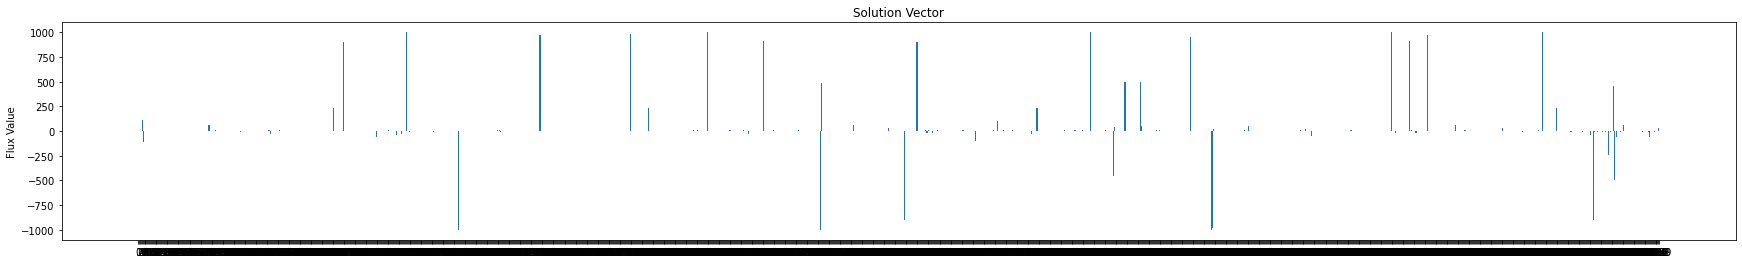

In [ ]:
# Display solution vector
v_pos = np.arange(len(solution.fluxes))
f = plt.figure() 
f.set_figwidth(30) 
plt.bar(v_pos, solution.fluxes, align='center')
plt.xticks(v_pos)
#f.set_figheight(8) 
plt.ylabel('Flux Value')
plt.title('Solution Vector')
plt.show()

Sometimes helpful: print only nonzero fluxes

In [ ]:
# OUTPUTS OF FBA: Display all nonzero fluxes

for x in model.reactions:
    if x.flux != 0:
        print("%s ; %s ; %f" % (x.id, x.name, x.flux))


12DGR161tipp ; 1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C16:1) ; 0.009933
3HAACOAT140 ; 3 Hydroxyacyl ACPCoA Transacylase ; -0.010278
4HBAt ; MNXR68734 ; -0.000029
A5PISO ; Arabinose-5-phosphate isomerase ; 0.005139
AACPS3 ; Acyl-[acyl-carrier-protein] synthetase  (n-C16:0) ; 0.036722
AADa ;  ; -0.584882
AADb ;  ; -0.584882
AALDCDLsi ; Aminoacetaldehyde CO2 ligase  spontaneous reaction  ; 4.775218
ACACT7r ; Acetyl-CoA C-acyltransferase (tetradecanoyl-CoA) (r) ; 0.010278
ACALDt ; Acetaldehyde reversible transport ; -6.437607
ACCOAC ; Acetyl-CoA carboxylase ; 0.318723
ACHBS ; 2-aceto-2-hydroxybutanoate synthase ; 0.038369
ACLSb ; Acetolactate synthase (step 2) ; 0.115462
ACOAD23f ; Acyl CoA dehydrogenase  cis hexadec 9 enoyl CoA  ; 0.010278
ACONT ; Aconitate hydratase ; 0.141526
ADAPAT ; E N-acetyl-L,L-diaminopimelate aminotransferase ; -0.660917
ADCL ; 4-aminobenzoate synthase ; 0.000088
ADCS ; 4-amino-4-deoxychorismate synthase ; 0.000088
ADK1 ; Adenylate ki

Print out other useful information

## Analyze growth dependence on Oxygen availability

In [ ]:
model.metabolites.atp_c.summary()

0 0.0 0.21166294973531077 8.50358527796129
1 2.1052631578947367 0.28744631877767024 10.073075173400344
2 4.2105263157894735 0.36322968782003 11.642565068839406
3 6.315789473684211 0.4390130568623898 13.212054964278472
4 8.421052631578947 0.507740109115464 11.263784088990292
5 10.526315789473683 0.576154096577546 9.59685600394479
6 12.631578947368421 0.6445680840396282 8.361560503765066
7 14.736842105263158 0.711796360484082 7.07470005190042
8 16.842105263157894 0.7601232733633038 4.965845130447358
9 18.94736842105263 0.8084501862425251 2.856990208994298
10 21.052631578947366 0.8567770991217468 0.7481352875412419
11 23.157894736842103 0.8739215069684302 0.0
12 25.263157894736842 0.8739215069684305 0.0
13 27.36842105263158 0.8739215069684302 0.0
14 29.473684210526315 0.8739215069684305 0.0
15 31.57894736842105 0.8739215069684305 0.0
16 33.68421052631579 0.8739215069684302 0.0
17 35.78947368421053 0.8739215069684305 0.0
18 37.89473684210526 0.8739215069684304 0.0
19 40.0 0.873921506968430

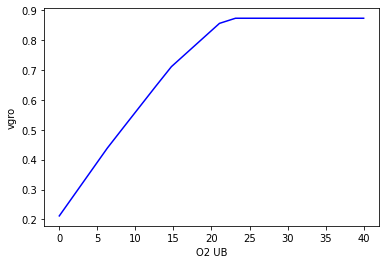

Text(0, 0.5, 'Acetate secretion')

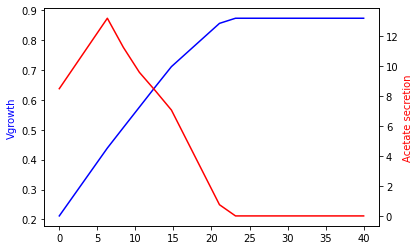

In [ ]:
# DEPENDENCE ON OXYGEN AVAILABILITY

n_points = 20
O2vec = np.linspace(0,40,n_points) # choose vector of O2 max flux
vgro = np.zeros(O2vec.size) # initialize vector of growth rates
vinteresting = np.zeros(O2vec.size) # initialize vector of other interesting flux to monitor
original_upper_bound = model.reactions.EX_o2_e.lower_bound

# Loop on all O2 upper bounds:
for j in range(0,O2vec.size):
  model.reactions.EX_o2_e.lower_bound = -O2vec[j]
  # RUNNING FBA
  solution = model.optimize()
  vgro[j]=solution.objective_value
  vinteresting[j]=solution.fluxes.EX_ac_e
  print(j,O2vec[j],solution.objective_value,vinteresting[j])

model.reactions.EX_o2_e.lower_bound = original_upper_bound

# plot results
plt.plot(O2vec,vgro,'b')
plt.xlabel('O2 UB')
plt.ylabel('vgro')
plt.show()

# Now plot also interesting flux (Acetate secretion)
ax = plt.subplot(111)
ax.plot(O2vec,vgro,'b')
ax2 = plt.twinx(ax)
ax2.plot(O2vec,vinteresting,'r')

ax.set_ylabel('Vgrowth', color='b')
ax2.set_ylabel('Acetate secretion', color='r')

## Parsimonious FBA

Performs secondary minimization of the sum of absolute fluxes of all reactions.

In [ ]:
#RUN Parsimonious FBA
pfba_solution = cobra.flux_analysis.pfba(model)


plt.plot(solution.fluxes,pfba_solution.fluxes,'o')
plt.xlabel('Regular FBA')
plt.ylabel('Parsimonious FBA')
plt.show()


## Flux Variability Analysis (FVA)

In [ ]:
# RUN FVA
from cobra.flux_analysis import flux_variability_analysis
fva_results = flux_variability_analysis(model, model.reactions) # WHY DOESN'T IT WORK UNTIL n?

print(fva_results)


## Questions

1. In this case there is a one-to-one correspondence between genes and reactions. Is this always the case? How does the deletion of a gene affect reaction fluxes? How are gen knockouts performed in cobrapy?
2. Cobrapy provides as an outcome of the LP optimization also the shadow prices (solution.shadow_prices). What are they? What is a possible biological meaning?

#**PART 4: Dynamic FBA**

The concept of dynamic FBA was originally proposed in Mahadevan et al, "Dynamic flux balance analysis of diauxic growth in Escherichia coli", Biophys J 2002 Sep;83(3):1331-40 (https://www.sciencedirect.com/science/article/pii/S0006349502739039?via%3Dihub). We follow here the most commonly used Static  Optimization Approach (SOA).

Quoting Mahadevan et al.:  "This approach involves dividing the batch time into several time intervals and solving the instantaneous optimization problem at the beginning of each time interval, followed by integration over the interval.
The dynamic equations were integrated assuming that the fluxes were constant over the interval. The optimization problem was then formulated at the next time instant and solved."

Note the dFBA can also include constraints on the rate of change of fluxes, as well as other constraints/variations at each optimization step (e.g. constraints on a weighted sum of fluxes, as in CAFBA, or alternative/sequential objective function, as in parsimonious FBA).

A description of dFBA for the study of microbial communities can be found in Harcombe et al., Metabolic Resource Allocation in Individual Microbes Determines Ecosystem Interactions and Spatial Dynamics, Cell Reports 2014 (https://www.sciencedirect.com/science/article/pii/S2211124714002800). This paper also includes analyses of sensitivity to parameters, and a discussion on the choice of the time interval. 

The dFBA tool for Computation of Microbial Ecosystems in Time and Space (COMETS), described in the Harcombe et al. paper, can be downloaded in its latest version at http://runcomets.org. A full description of its capabilities and examples is available at Dukovski et al., https://arxiv.org/abs/2009.01734.

##Diauxic shift with a rudimentary dFBA script 

(NOTE: running this script requires having installed and imported libraries and E. coli model from Part 3)

In [ ]:
"Get number of carbons associated with each exchange reaciton"
c_ex_rxns = {r.id: m.elements['C'] for m in model.metabolites for r in m.reactions if 'C' in m.elements if r.compartments == {'e'}}
c_ex_rxns

{'EX_ac_e': 2,
 'EX_acald_e': 2,
 'EX_akg_e': 5,
 'EX_co2_e': 1,
 'EX_etoh_e': 2,
 'EX_for_e': 1,
 'EX_fru_e': 6,
 'EX_fum_e': 4,
 'EX_glc__D_e': 6,
 'EX_gln__L_e': 5,
 'EX_glu__L_e': 5,
 'EX_lac__D_e': 3,
 'EX_mal__L_e': 4,
 'EX_pyr_e': 3,
 'EX_succ_e': 4}

In [ ]:
# Michael Silverstein's CUE function (outdated)
def cCUE(solution, c_ex_rxns=None, model=None):
  """
  Compute CUE using the following definition

        sum(uptake C) - sum(secretion C)
  CUE = --------------------------------
                  sum(uptake C)

  Find number of carbons for each exchange reaction if `c_ex_rxns` not provided
  (requires providing a `model`)
  """
  # Find number of carbons for each exchange reaction if not provided
  if not c_ex_rxns:
    assert model, 'If `c_ex_rxns` is not provided, you must provide a `model`'
    c_ex_rxns = {r.id: m.elements['C'] for m in model.metabolites for r in m.reactions if 'C' in m.elements if r.compartments == {'e'}}

  # Get C fluxes (flip signs so that uptake is positive)
  c_ex_fluxes = np.array([solution.get_primal_by_id(r) * -c for r, c in c_ex_rxns.items()])

  # Calculate CUE
  cue = c_ex_fluxes.sum() / c_ex_fluxes[c_ex_fluxes > 0].sum()

  return cue

In [ ]:
# My super-simple dFBA
t_n = 100 # number of time points
dt=0.5 # Time interval

# Michaelis-Menten parameters for uptake
KM=0.5 
Vmax=2 

t_vec = list(range(0,t_n))
DFBA_biomass = [0] * t_n # initialize vector of glucose amounts
DFBA_GLC = [0] * t_n # initialize vector of glucose amounts
DFBA_ACE = [0] * t_n # initialize vector of acetate amounts
DFBA_CUE = [0] * t_n # initialize vector of acetate amounts

DFBA_biomass[0]=0.1 # Initial amount of biomass
DFBA_GLC[0]=20.0 # Initial amount of glucose
DFBA_ACE[0]=0.0 # Initial amount of acetate

# We limit O2, so the cell will secrete acetate
model.reactions.EX_o2_e.lower_bound=-2
# We lower the maintenance flux so acetate is not all lost in meintenance
model.reactions.ATPM.lower_bound=1
model.reactions.ATPM.upper_bound=1


# Start loop on time intervals ------------------------------------------------
for t_i in t_vec[1:]: 
  # Compute glucose uptake rate using Michaelis-Menten
  DFBA_GLC_uptake = Vmax * DFBA_GLC[t_i-1]/(KM + DFBA_GLC[t_i-1])
  DFBA_ACE_uptake = Vmax * DFBA_ACE[t_i-1]/(KM + DFBA_ACE[t_i-1])

  # Impose Michaelis-Menten rate as maximal uptake rate for extracellular metabolites
  model.reactions.EX_glc__D_e.lower_bound = - DFBA_GLC_uptake
  model.reactions.EX_ac_e.lower_bound = - DFBA_ACE_uptake

  # Compute standard FBA solution (and check if feasible)
  solution = model.optimize()
  if(solution.status=='optimal'):
    vgrowth = solution.fluxes.Biomass_Ecoli_core
    v_GLC = solution.fluxes.EX_glc__D_e
    v_ACE = solution.fluxes.EX_ac_e
  else:
    vgrowth=0
    v_GLC=0
    v_ACE=0
  
  # Update Biomass amount
  DFBA_biomass[t_i]=DFBA_biomass[t_i-1] + vgrowth*DFBA_biomass[t_i-1]*dt

  # Update glucose amount
  DFBA_GLC[t_i]=DFBA_GLC[t_i-1] + v_GLC*DFBA_biomass[t_i-1]*dt
  if(DFBA_GLC[t_i]<0):
    DFBA_GLC[t_i]=0

  # Update acetate amount
  DFBA_ACE[t_i]=DFBA_ACE[t_i-1] + v_ACE*DFBA_biomass[t_i-1]*dt
  if(DFBA_ACE[t_i]<0):
    DFBA_ACE[t_i]=0

  DFBA_CUE[t_i] = cCUE(solution, c_ex_rxns)
# End loop on time intervals ------------------------------------------------


/usr/local/lib/python3.7/dist-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


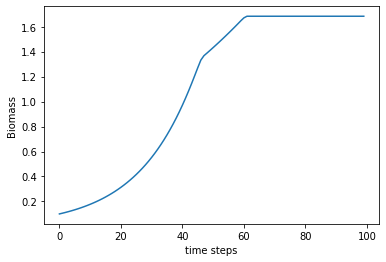

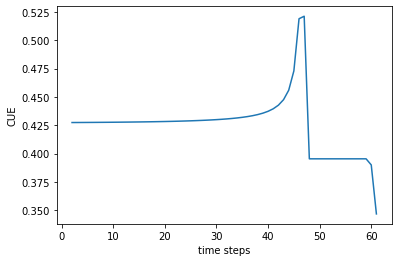

Text(0, 0.5, 'Extracellular Acetate')

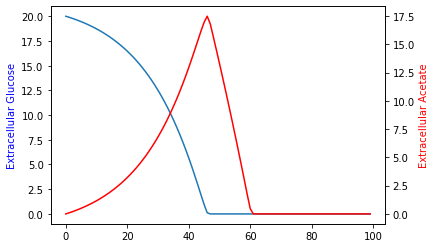

In [ ]:
# plot results
plt.plot(t_vec,(DFBA_biomass))
plt.xlabel('time steps')
plt.ylabel('Biomass')
plt.show()

plt.plot(t_vec[2:],DFBA_CUE[2:])
plt.xlabel('time steps')
plt.ylabel('CUE')
plt.show()

ax = plt.subplot(111)
ax.plot(t_vec,DFBA_GLC)
ax2 = plt.twinx(ax)
ax2.plot(t_vec,DFBA_ACE, color='r')

ax.set_ylabel('Extracellular Glucose', color='b')
ax2.set_ylabel('Extracellular Acetate', color='r')



## Questions

1. Can you extend this to two organisms (e.g. two variants of E. coli, one incapable of respiring)

## A dFBA from the cobrapy package

Copied as is from: https://cobrapy.readthedocs.io/en/latest/dfba.html


In [ ]:
# DYNAMIC FBA (from https://cobrapy.readthedocs.io/en/latest/dfba.html)

import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [ ]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )


t = 5.804: : 185it [00:43,  4.22it/s]


Text(0, 0.5, 'Glucose')

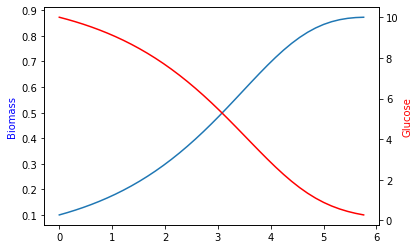

In [ ]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')